In [23]:
import sys, os
pwd = os.path.abspath('../')
if pwd not in sys.path:
    sys.path.append(pwd)

from scripts import data_processing as dp
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

In [24]:
arduino_port = dp.list_ports(return_arduino_port=True)
print(arduino_port)

/dev/cu.Bluetooth-Incoming-Port: n/a [n/a]
/dev/cu.usbmodem101: Arduino Due [USB VID:PID=2341:003E LOCATION=0-1]
/dev/cu.usbmodem101


In [25]:
com_port = arduino_port
freq_hz = 100
update_per_period = 10
report_per_update = 5
baud_rate = 2000000 # Irrelevant if you use native port (as you should)
report_period_us = 1e6 / freq_hz / update_per_period / report_per_update

In [26]:
save_dir = os.path.join(pwd, 'data')
save_path = os.path.join(save_dir, 'waveform_data.npz')

data_count = 200
time_out = 0.1
discard_first_n = 1
if not dp.check_baudrate(report_period_us, baud_rate):
    sys.exit()
v_out_data = [int(x) for x in dp.readserial(com_port, baud_rate, time_out, data_count, discard_first_n)]
data_time_us_ls = [report_period_us * i for i in range(len(v_out_data))]
Path(save_dir).mkdir(parents=True, exist_ok=True)
np.savez(save_path, v_out=v_out_data, timestamp=data_time_us_ls)

Required baudrate: 200000
Selected baudrate: 2000000
Selected baudrate is sufficient.


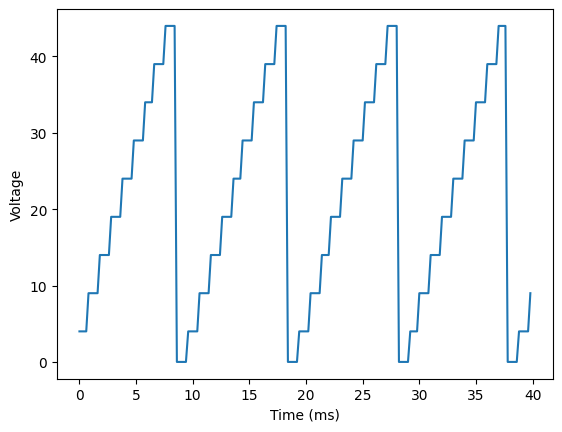

In [27]:
result = np.load(save_path)
_ = plt.plot(result['timestamp'] / 1e3, result['v_out'])
_ = plt.xlabel('Time (ms)')
_ = plt.ylabel('Voltage')

In [28]:
ft_v_out = np.fft.fft(result['v_out'] - np.mean(result['v_out']))
ft_freq = np.fft.fftfreq(len(result['v_out']), d=report_period_us / 1e6)
sorted_zip_ls = sorted(zip(ft_freq, ft_v_out), key=lambda x: x[0])
ft_freq, ft_v_out = zip(*sorted_zip_ls)
ft_freq = ft_freq[len(ft_freq) // 2:]
ft_v_out = ft_v_out[len(ft_v_out) // 2:]

Dominant frequency: 100.0


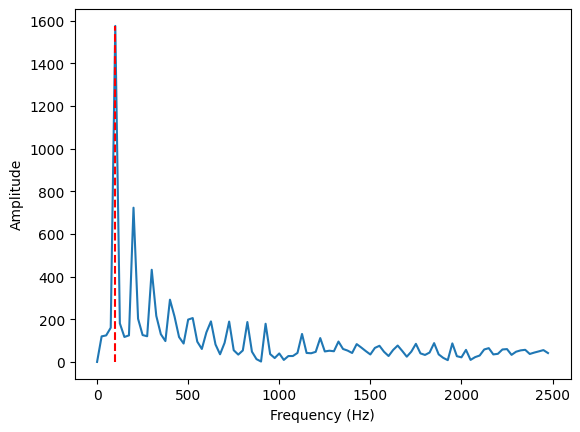

In [29]:
plt.plot(ft_freq, np.abs(ft_v_out))
max_freq = ft_freq[np.argmax(np.abs(ft_v_out))]
max_amp = np.max(np.abs(ft_v_out))
plt.vlines(max_freq, 0, max_amp, colors='r', linestyles='dashed')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
print(f'Dominant frequency: {max_freq}')